https://www.analyticsvidhya.com/blog/2020/11/attention-mechanism-for-caption-generation/#h2_7

https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa

# Image Caption Generation with Attention Mechanism in TensorFlow


## Contents

1. [Introduction](#introduction)
1. [Setup and Preparation](#setup-and-preparation)
1. [Gathering the Data](#gathering-the-data)
1. [Preparing the Dataset](#preparing-the-dataset)
1. [Set Up Tokenizer](#set-up-tokenizer)

## Introduction

---

The attention mechanism is a complex cognitive ability that human beings possess. When people receive information, they can consciously ignore some of the main information while ignoring other secondary information.

This ability of self-selection is called attention. The attention mechanism allows the neural network to have the ability to focus on its subset of inputs to select specific features. 

The model architecture used here is based on the TensorFlow [tutorial](https://www.tensorflow.org/tutorials/text/image_captioning) and inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder.

## Problem Statement

To train an image caption generator model with a BLEU-1 score of at least 0.4.

## Setup and Preparation

---

I will be leveraging Google Colab for our training, so I'll first need to prepare the environment and ensure the required packages are installed and imported.

While files can be hosted in Google Drive and accessed in Google Colab, reading data from Google Drive appears to be significantly slower, so I'll download the files to the Colab virtual machine and process from there. I've hosted the [Flickr30k](https://www.kaggle.com/datasets/eeshawn/flickr30k) dataset in Kaggle, so I'll be downloading directly from the command line with the Kaggle API. This requires the use of an individual [API token](https://www.kaggle.com/docs/api#getting-started-installation-&-authentication) which you can generate. I have saved mine in my Google Drive for easy access.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# update to tensorflow 2.11.0 in Colab's environment to make use of new features
!pip uninstall -y tensorflow keras

Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Successfully uninstalled tensorflow-2.9.2
Found existing installation: keras 2.9.0
Uninstalling keras-2.9.0:
  Successfully uninstalled keras-2.9.0


In [ ]:
!pip install -U tensorflow_text==2.11.0 tensorflow==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 21.4 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
  

In [ ]:
# utilise einops to manipulate our tensors
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 831.8 kB/s eta 0:00:00


In [ ]:
# loading and preparing the Kaggle credentials
!mkdir ~/.kaggle
# copy the API token from my Google Drive
!cp /content/drive/MyDrive/Capstone/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# downloading and unzipping the files to the virtual machine
!kaggle datasets download -d eeshawn/flickr30k
!unzip -q /content/flickr30k.zip -d /content/flickr30k/

100% 4.08G/4.08G [03:05<00:00, 25.4MB/s]
100% 4.08G/4.08G [03:05<00:00, 23.7MB/s]


In [ ]:
# import libraries
from collections import Counter
import einops
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import os
import pandas as pd
from random import sample
import re
import string
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

In [ ]:
# set seed for results reproducibility
RNG = 42
tf.keras.utils.set_random_seed(RNG)

# specify constants and paths
BATCH_SIZE = 32
BUFFER_SIZE = 10000

WORKSPACE_PATH = "/content/drive/MyDrive/Capstone/"
IMAGES_PATH = "/content/flickr30k/flickr30k_images"
CAPTIONS_PATH = "/content/flickr30k/captions.txt"
MODEL_PATH = os.path.join(WORKSPACE_PATH, "models")
CHECKPOINT_PATH = "/tmp/checkpoint"

## Gathering the Data

---

There are various available datasets that are suitable for the purpose of our training, but I will be utilising the [Flickr30k](https://shannon.cs.illinois.edu/DenotationGraph/) dataset in this project, a popular free dataset for use with image caption generation. The dataset consists of 158,915 crowd-sourced captions describing 31,783 images. The dataset is still relatively small enough for us to be able to train in a Google Colab environment or local machine without an extensive training duration.

Larger and more robust datasets to consider include Microsoft's [COCO Captions](https://cocodataset.org/) dataset with over 1.5 million captions describing over 330,000 images or even Google's [Conceptual Captions Dataset](https://ai.google.com/research/ConceptualCaptions/) with around 3.3 million image and caption pairs! However, the size of these datasets would also require significantly higher resources and computation power to complete training.

In [ ]:
# check our dataset
print(f"Total Images in Dataset = {len(os.listdir(IMAGES_PATH)):,}")

with open(CAPTIONS_PATH, encoding="utf8") as f:
    data_raw = [line.rstrip("\n") for line in f.readlines()]
    data_dict = {}
    for line in data_raw[1:]:
        image_name, _, caption = line.split(",")
        if image_name not in data_dict:
            data_dict[image_name] = []
        data_dict[image_name].append(caption)

print(f"Total Images in Captions = {len(data_dict):,}")


Total Images in Dataset = 31,783
Total Images in Captions = 31,783


Let's get a sense of our dataset by extracting some random samples, displaying the image as well as the 5 accompanying captions.

In [ ]:
def get_captions(image: str) -> list:
    captions = data_dict[image]
    return list(captions)


def check_random_sample(n: int=5):
    if type(n) != int:
        raise TypeError("n must be an integer")
    elif n <= 0:
        raise ValueError("n must be greater than 0")

    fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, n * 4), squeeze=False)
    image_samples = sample(data_dict.keys(), n)
    for idx, image in enumerate(image_samples):
        filepath = os.path.join(IMAGES_PATH, image)
        image_load = tf.keras.utils.load_img(filepath)
        ax[idx, 0].imshow(image_load)
        ax[idx, 0].axis("off")
        ax[idx, 0].set_title(image, fontsize=20)
        captions = get_captions(image)
        ax[idx, 1].set_ylim(0, len(captions))
        for i, caption in enumerate(captions):
            ax[idx, 1].text(0, i + 0.25, caption, fontsize=20)
            ax[idx, 1].axis("off")

    fig.tight_layout()
    plt.show()

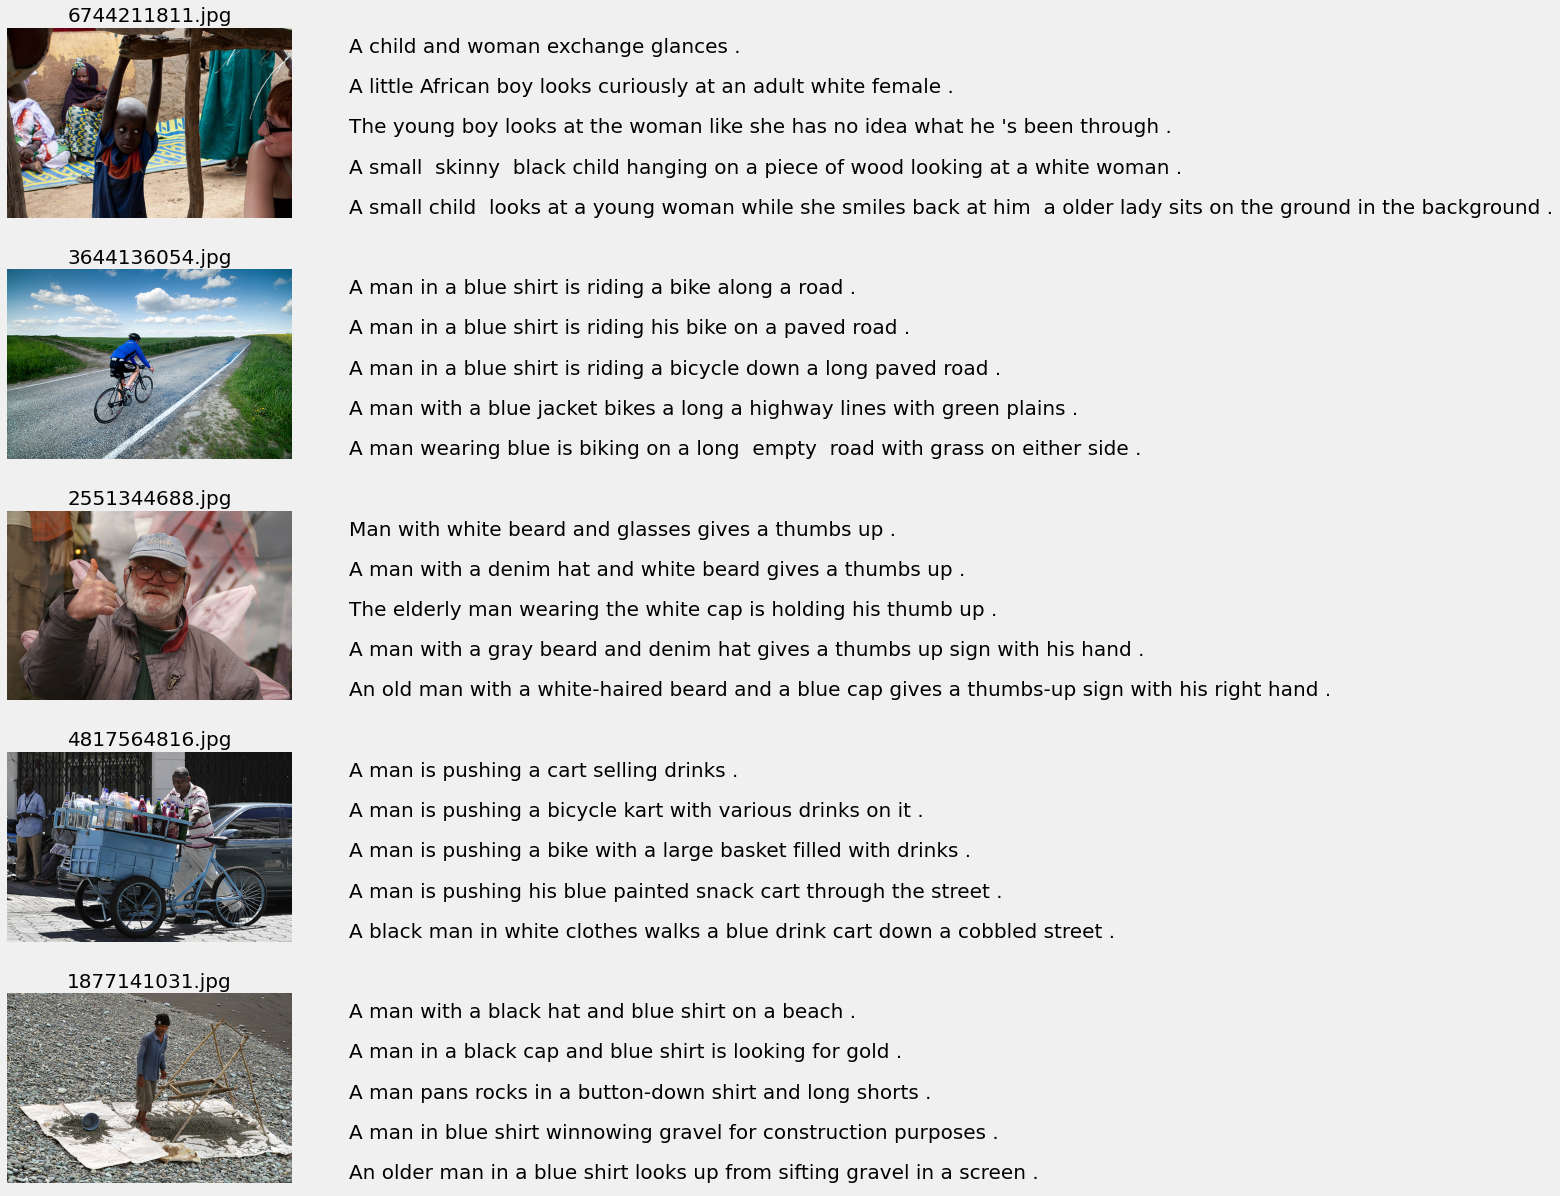

In [ ]:
check_random_sample(5)

In [ ]:
check_random_sample(5)

From the samples, we see that the images in the dataset mostly depict day to day activities, with captions that vary in terms of complexity and details. Most of the captions use more general terms to describe the scene, while some go into very specific details.

Let's clean up our captions by removing the extra whitespaces and punctuations.

In [ ]:
def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r'[^\w\s]', ' ', caption)
    # remove excess whitespace
    caption = " ".join([word for word in caption.split()])
    return caption

In [ ]:
def check_length() -> tuple[int, Counter]:
    '''
    Check and print statistics of the captions within the dataset.

    Returns the max_length and a word_count Counter.
    '''
    # set arbitrary min_length for comparison
    min_length = 100
    max_length = 0

    # pass a list of tokens from the corpus into the Counter
    tokens = list()

    for captions in data_dict.values():
        for caption in captions:
            caption = clean_caption(caption)
            caption_tokens = caption.split()
            # store tokens
            tokens.extend(caption_tokens)
            # check length
            caption_length = len(caption_tokens)
            if caption_length < min_length:
                min_length = caption_length
                shortest_caption = caption
            if caption_length > max_length:
                max_length = caption_length
                longest_caption = caption

    word_count = Counter(tokens)

    print(
        f"The shortest caption has {min_length} words, and the longest caption has {max_length} words"
    )
    print()
    print(f"Shortest caption: {shortest_caption}")
    print(f"Longest caption: {longest_caption}")
    print()
    print(f"There are {len(word_count):,} unique words in the corpus with a total of {len(tokens):,} words.")

    return max_length, word_count

In [ ]:
max_length, word_count = check_length()

The shortest caption has 2 words and the longest caption has 78 words

Shortest caption: two skateboarders
Longest caption: a man wearing a helmet red pants with white stripes going down the sides and a white and red shirt is on a small bicycle using only his hands while his legs are up in the air while another man wearing a light blue shirt with dark blue trim and black pants with red stripes going up the sides is standing nearby gesturing toward the first man and holding a small figurine of one of the seven dwarves

There are 20,007 unique words in the corpus with a total of 1,948,636 words.


Given that the annotations are crowd sourced, it may not be entirely surprising that the shortest and longest captions in the dataset differ to such an extent in terms of length and details.

In [ ]:
# convert Counter into DataFrame for visualisation
def generate_df(dict):
    df = pd.DataFrame(dict.items(), columns=["Word", "Count"])
    df = df.sort_values(by="Count", ascending=False)
    df["Percent"] = df["Count"] / df["Count"].sum()
    return df

In [ ]:
df = generate_df(word_count)

In [ ]:
def plot_n_words(dataframe: pd.DataFrame, n: int=20):
    '''
    Plot top n most and least frequently appearing words in the corpus.
    '''
    fig, (ax1, ax2) = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(20,n/2)
    )
    ax1.barh(
        data=dataframe[["Word", "Count"]].head(n),
        y="Word",
        width="Count",
        )
    ax1.set_title(f"{n} Most Frequently Appearing Words")
    
    ax2.barh(
        data=dataframe[["Word", "Count"]].tail(n),
        y="Word",
        width="Count",
    )
    ax2.set_title(f"{n} Least Frequently Appearing Words")

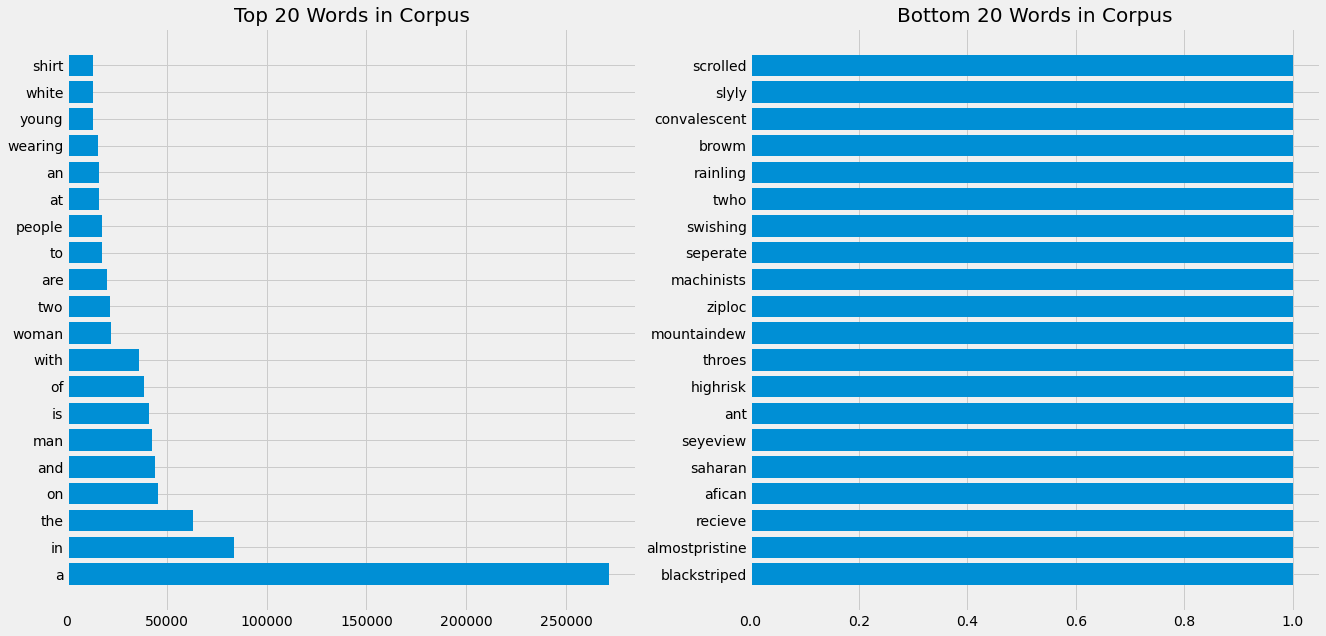

In [ ]:
plot_n_words(df, 20)

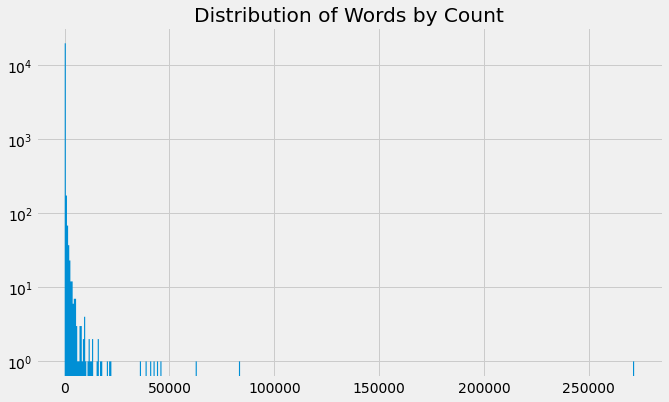

In [250]:
plt.figure(figsize=(10,6))
plt.title("Distribution of Word Count")
plt.hist(
    df["Count"], 
    log=True, 
    bins=500, 
    histtype="stepfilled"
    );

We see that articles and prepositions are among the most frequently appearing words, which would be expected as part of sentence construction. However, the article "a" is somewhat of an outlier as can be seen from the histogram, appearing over 250,000 times within the corpus. While helpful in proper sentence construction, we should be able to safely remove it from our model for our use case. We will refine our `clean_caption` function to remove single letter words from our captions and run the function again.

In [251]:
def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r'[^\w\s]', ' ', caption)
    # remove single letter words, e.g. 'a'
    caption = " ".join([word for word in caption.split() if len(word) > 1])
    return caption

In [252]:
max_length, word_count_clean = check_length()

The shortest caption has 1 words and the longest caption has 72 words

Shortest caption: snowboarder
Longest caption: man wearing helmet red pants with white stripes going down the sides and white and red shirt is on small bicycle using only his hands while his legs are up in the air while another man wearing light blue shirt with dark blue trim and black pants with red stripes going up the sides is standing nearby gesturing toward the first man and holding small figurine of one of the seven dwarves

There are 19,974 unique words in the corpus with a total of 1,673,099 words.


In [253]:
df_clean = generate_df(word_count_clean)

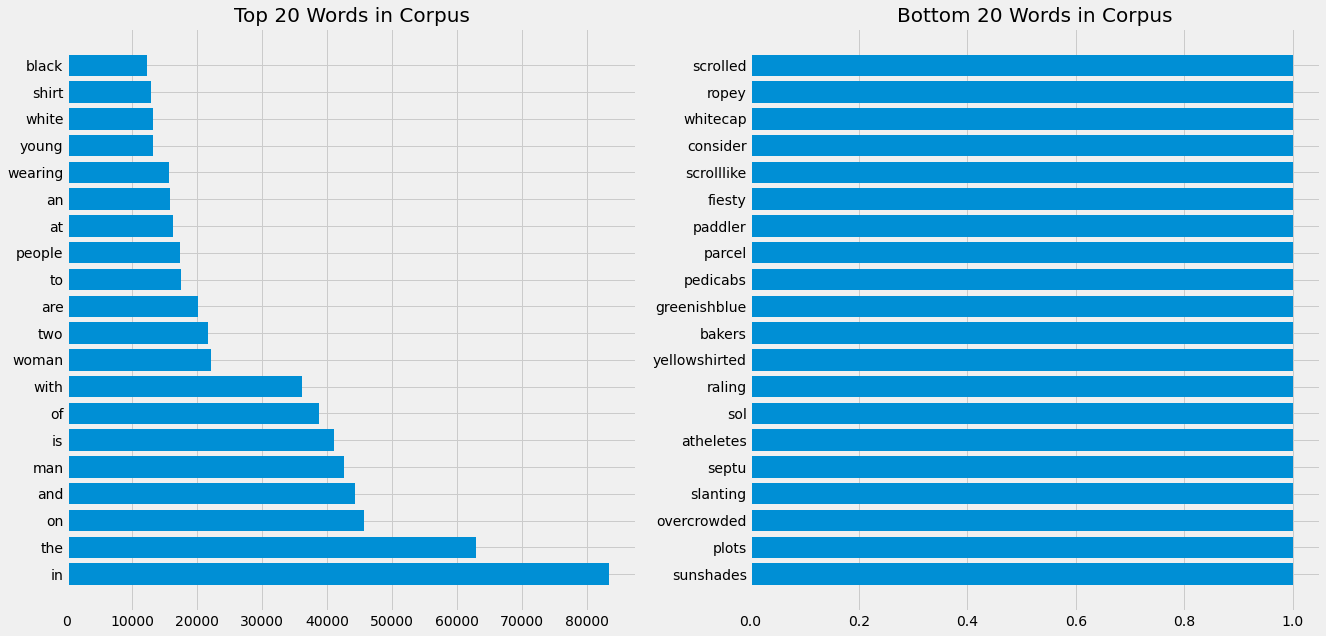

In [254]:
plot_n_words(df_clean, 20)

On the other hand, with the least frequently appearing words, as expected we see that there are significant proportions of words that appear only rarely within the entire corpus. While such words can help to describe the specific photo in detail, they would not likely be helpful in building a model with high generalisability and can be removed from our model.

In [255]:
# check word count at various percentiles in the dataset
df_clean.Count.quantile(np.linspace(.1, 1, 9, 0))

0.1     1.0
0.2     1.0
0.3     1.0
0.4     2.0
0.5     3.0
0.6     4.0
0.7     8.0
0.8    17.0
0.9    55.7
Name: Count, dtype: float64

In [256]:
df_clean.query("Count >= 8").describe()

Count      Percent
count   6085.000000  6085.000000
mean     270.079869     0.000161
std     2112.349787     0.001263
min        8.000000     0.000005
25%       13.000000     0.000008
50%       28.000000     0.000017
75%       86.000000     0.000051
max    83466.000000     0.049887

Looking at the various percentiles of our dataset, most of the words in the corpus only appear in very few captions. At the 70th percentile, the words only appear 8 times throughout the captions. However, this gives us around 6,000 words for the model to train on, which should be sufficient in training our model. When we set up our TextTokenization layer, we will specify the vocabulary size to consider only the top 6,000 words for our model.

## Preparing the Dataset

---

Next, I will convert the dataset into the TensorFlow dataset format to better optimise the training workflow with a data pipeline. The dataset will be split into 3: train, validation and test sets.

Train and validation will be used by the model during training, while the test set will be set aside for final evaluation.

In [94]:
def generate_dataset(data: dict, sample_size: int=None, validation_size: float=0.2,):
    '''
    If sample_size is defined, samples will be split into train and validation sets, while remaining samples in the dataset will be kept as test data for evaluation after model training.

    If sample_size is undefined, dataset will split into train and validation sets only.

    Returns
        TensorFlow Dataset
    '''
    if sample_size:
        train_val_keys = sample(data.keys(), sample_size)
        val_key_size = int(validation_size * sample_size)
        val_keys = sample(train_val_keys, val_key_size)
        train_keys = [key for key in train_val_keys if key not in val_keys]
        test_keys = [key for key in data.keys() if key not in train_val_keys]
    else:
        val_key_size = int(validation_size * len(data))
        val_keys = sample(data.keys(), val_key_size)
        train_keys = [key for key in data.keys() if key not in val_keys]

    # join full path to image name for retrieval during feature extraction
    train_captions = [
        (os.path.join(IMAGES_PATH, key), val)
        for key, val in data.items()
        if key in train_keys
    ]

    val_captions = [
        (os.path.join(IMAGES_PATH, key), val)
        for key, val in data.items()
        if key in val_keys
    ]

    train_raw = tf.data.experimental.from_list(train_captions)
    val_raw = tf.data.experimental.from_list(val_captions)

    if test_keys:
        test_captions = [
            (os.path.join(IMAGES_PATH, key), val)
            for key, val in data.items()
            if key in test_keys
        ]
        print(f"Data split into {len(train_captions):,} train, {len(val_captions):,} validation and {len(test_captions):,} test.")
        # return test_captions for BLEU score evaluation after training
        return train_raw, val_raw, test_captions
    else:
        print(f"Data split into {len(train_captions):,} train and {len(val_captions):,} validation.")
        return train_raw, val_raw


In [95]:
sample_size = 30720
val_size = 0.2

train_raw, val_raw, test_captions = generate_dataset(data_dict, sample_size=sample_size, validation_size=val_size)

Data split into 25427 samples in train, 6356 samples in test


Extracting one sample from our dataset, we see that it is a pair of Tensors, consisting of an image path string together with the 5 captions for each image.

In [96]:
for ex_path, ex_captions in train_raw.take(1):
    print(ex_path)
    print(ex_captions)

tf.Tensor(b'/content/flickr30k/flickr30k_images/1000092795.jpg', shape=(), dtype=string)
tf.Tensor(
[b'two young guys with shaggy hair look at their hands while hanging out in the yard'
 b'two young white males are outside near many bushes'
 b'two men in green shirts are standing in yard'
 b'man in blue shirt standing in garden'
 b'two friends enjoy time spent together'], shape=(5,), dtype=string)


### Image Feature Extraction

Using transfer learning with a pre-trained image classifier model, we can extract the features from our images. Since we are not trying to perform classification, `include_top=False` returns the model without the classification layer and allows us to extract the feature maps.

## Why use MobileNet?

The MobileNet model that we will be using for feature extraction takes an input image shape of 224 x 224 pixels and 3 x RGB channels, so we will need to reshape our images when passing into the model. We will drop the image classification layer from the MobileNet model and utilise the hidden layers to extract the features from our images to pass into our model.

In [97]:
feature_extractor = tf.keras.applications.MobileNetV3Small(
    include_top=False,
    include_preprocessing=True,
    input_shape=(224, 224, 3),
)

# Freeze the base_model
feature_extractor.trainable = False

4334752/4334752 [==============================] - 0s 0us/step


In [275]:
def load_image(image_path, image_shape=(224, 224, 3), preserve_aspect_ratio=False):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_shape[:-1], preserve_aspect_ratio=preserve_aspect_ratio)
    return img

In [276]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(feature_extractor(test_img_batch).shape)


(1, 224, 224, 3)
(1, 7, 7, 576)


The feature extractor takes in the image of shape (224, 224, 3) and returns a feature map of shape (7, 7, 576).

### Set Up TextVectorization Layer

A TextVectorization layer will be used to transform our text captions into integer sequences. As mentioned previously, we will cap the vocabulary size of this layer to use only the top 6,000 most frequent words in the captions.

- Use adapt to iterate over all training captions, split the captions into words, and compute a vocabulary of the top 6,000 most frequent words.
- Attach a `[START]` prefix and `[END]` suffix to our captions to allow to determine the start and end of our captions.
- Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to the `max_length` of our captions.
- Create word-to-index and index-to-word mappings to display results.

In [100]:
def standardize(s):
    s = tf.strings.lower(s)
    s = tf.strings.regex_replace(s, f"[{re.escape(string.punctuation)}]", "")
    s = tf.strings.join(["[START]", s, "[END]"], separator=" ")
    return s

In [101]:
# Use the top 6,000 tokens in vocabulary, including 1 out of vocabulary (OOV) token and 1 for masked locations ("0")
vocabulary_size = 6000 + 1 + 1
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size, standardize=standardize, ragged=True
)

In [102]:
tokenizer.adapt(train_raw.map(lambda fp, txt: txt).batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [103]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man', 'is']

The tokenizer now has a stored vocabulary of words, each with its own index value.

Using the `test_caption` below,  we see that the tokenizer converts the caption into a sequence of integers. Using the word_to_index and index_to_word mappings, we can convert the eventual outputs of our model back into text for interpretation.

In [ ]:
create error here

In [104]:
test_caption = "Two young guys with shaggy hair look at their hands while hanging out in the yard ."

In [107]:
test_caption_tokens = tokenizer(test_caption)
print(test_caption_tokens)

tf.Tensor(
[   2   13   20  330   11 2198  107  183   17   63  154   24  322   72
    4    5  490    3], shape=(18,), dtype=int64)


In [108]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

index_to_word = tf.keras.layers.StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

In [109]:
test_caption_words = index_to_word(test_caption_tokens)
tf.strings.reduce_join(test_caption_words, separator=" ", axis=-1).numpy()

b'[START] two young guys with shaggy hair look at their hands while hanging out in the yard [END]'

### Reshape and Tokenize

Currently, the datasets are in 1 image : 5 caption pairs, which will need to be converted into 1:1 pairs for training. During this conversion, the images will be loaded and the captions passed through the tokenizer, converting all the Tensors into numerical data.

Since the image features will not be changed, they can be generated in advance and stored in cache to save some time during training. The time it takes to set up the cache is earned back on each epoch during training and validation. 

In [110]:
def match_shapes(images, captions):
    caption_shape = einops.parse_shape(captions, "b c")
    captions = einops.rearrange(captions, "b c -> (b c)")
    images = einops.repeat(images, "b ... -> (b c) ...", c=caption_shape["c"])
    return images, captions


In [111]:
def prepare_txt(imgs, txts):
    tokens = tokenizer(txts)

    input_tokens = tokens[..., :-1]
    label_tokens = tokens[..., 1:]
    return (imgs, input_tokens), label_tokens


In [112]:
# def prepare_dataset(ds, tokenizer, batch_size=BATCH_SIZE, shuffle_buffer=BUFFER_SIZE):
#     # Load the images and make batches.
#     ds = (
#         ds.shuffle(shuffle_buffer)
#         .map(lambda path, caption: (load_image(path), caption), tf.data.AUTOTUNE)
#         .ignore_errors()
#         .batch(batch_size, drop_remainder=True)
#     )

#     def to_tensor(inputs, labels):
#         (images, in_tok), out_tok = inputs, labels
#         return (images, in_tok.to_tensor()), out_tok.to_tensor()

#     return (
#         ds.map(match_shapes, tf.data.AUTOTUNE)
#         .unbatch()
#         .shuffle(shuffle_buffer)
#         .batch(batch_size)
#         .map(prepare_txt, tf.data.AUTOTUNE)
#         .map(to_tensor, tf.data.AUTOTUNE)
#     )

In [113]:
# train_ds = prepare_dataset(train_raw, tokenizer)
# train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [114]:
# val_ds = prepare_dataset(val_raw, tokenizer)
# val_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [115]:
# def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=BATCH_SIZE):
#     # Load the images and make batches.
#     ds = (
#         ds.map(lambda path, caption: (load_image(path), caption))
#         .ignore_errors()
#         .batch(batch_size)
#     )

#     # Run the feature extractor on each batch
#     def gen():
#         for (images, captions) in tqdm(ds):
#             feature_maps = image_model(images)

#             feature_maps, captions = match_shapes(feature_maps, captions)
#             yield feature_maps, captions

#     # Wrap the generator in a new tf.data.Dataset.
#     new_ds = tf.data.Dataset.from_generator(
#         gen,
#         output_signature=(
#             tf.TensorSpec(shape=image_model.output_shape),
#             tf.TensorSpec(shape=(None,), dtype=tf.string),
#         ),
#     )

#     # Apply tokenization
#     new_ds = new_ds.map(prepare_txt, tf.data.AUTOTUNE).unbatch().shuffle(1000)

#     # Save the dataset into shard files.
#     def shard_func(i, item):
#         return i % shards

#     new_ds.enumerate().save(save_path, shard_func=shard_func)


In [116]:
# def load_dataset(save_path, batch_size=BATCH_SIZE, shuffle_buffer=BUFFER_SIZE, cycle_length=2):
#     def custom_reader_func(datasets):
#         datasets = datasets.shuffle(shuffle_buffer)
#         return datasets.interleave(lambda x: x, cycle_length=cycle_length)

#     ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

#     def drop_index(i, x):
#         return x

#     ds = (
#         ds.map(drop_index, tf.data.AUTOTUNE)
#         .shuffle(shuffle_buffer)
#         .padded_batch(batch_size)
#         .prefetch(tf.data.AUTOTUNE)
#     )
#     return ds


In [ ]:
def prepare_dataset(ds, image_model, tokenizer, batch_size=BATCH_SIZE, shuffle_buffer=BUFFER_SIZE):
    # Load the images and make batches.
    ds = (
        ds.map(lambda path, caption: (load_image(path), caption))
        .ignore_errors()
        .batch(batch_size)
    )

    # Run the feature extractor on each batch
    def gen():
        for (images, captions) in tqdm(ds):
            feature_maps = image_model(images)

            feature_maps, captions = match_shapes(feature_maps, captions)
            yield feature_maps, captions

    # Wrap the generator in a new tf.data.Dataset.
    new_ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=image_model.output_shape),
            tf.TensorSpec(shape=(None,), dtype=tf.string),
        ),
    )

    # Apply tokenization
    new_ds = (
        new_ds.map(prepare_txt, tf.data.AUTOTUNE)
        .unbatch()
        .shuffle(shuffle_buffer)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return new_ds


In [118]:
# save_dataset(train_raw, "train_cache", feature_extractor, tokenizer)
# save_dataset(val_raw, "val_cache", feature_extractor, tokenizer)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
train_ds = prepare_dataset(train_raw, feature_extractor, tokenizer)
train_ds.element_spec

In [ ]:
val_ds = prepare_dataset(val_raw, feature_extractor, tokenizer)
val_ds.element_spec

Good reading on buffer size

https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. 

https://keras.io/guides/transfer_learning/

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1. Take layers from a previously trained model.
1. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
1. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
1. Train the new layers on your dataset.

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting include_top=False returns the model without the final classification layer, so you can use the last layer of feature-maps:

In [119]:
# train_ds = load_dataset("train_cache")
# val_ds = load_dataset("val_cache")

In [120]:
# val_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## Preparing the Model

---

Since I will be using the pre-trained MobileNet as an image encoder, the model will be focusing on text decoding using a 2-layer Transformer-decoder.

The model will be implemented in three main parts:

1. Input - The token embedding and positional encoding (SeqEmbedding).
1. Decoder - A stack of transformer decoder layers (DecoderLayer) where each contains:
    1. A causal self attention later (CausalSelfAttention), where each output location can attend to the output so far.
    1. A cross attention layer (CrossAttention) where each output location can attend to the input image.
    1. A feed forward network (FeedForward) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.

---

In TF.Keras there are basically three-way we can define a neural network, namely

Sequential API
Functional API
Model Subclassing API
Among them, Sequential API is the easiest way to implement but comes with certain limitations. For example, with this API, we can’t create a model that shares feature information with another layer except to its subsequent layer. In addition, multiple input and output are not possible to implement either. At this point, Functional API does solve these issues greatly. A model like Inception or ResNet is feasible to implement in Functional API. But often deep learning researcher wants to have more control over every nuance of the network and on the training pipelines and that’s exactly what Model Subclassing API serves. Model Sub-Classing is a fully customizable way to implement the feed-forward mechanism for the custom-designed deep neural network in an object-oriented fashion.

https://towardsdatascience.com/model-sub-classing-and-custom-training-loop-from-scratch-in-tensorflow-2-cc1d4f10fb4e

### Input

While the captions have been tokenized and converted into integers, the Transformer's attention layers will not recognise the sequence and just sees an unordered set of numbers. 

A `SeqEmbedding` layer will do the following:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

In [121]:
class SeqEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, max_length, depth):
        super().__init__()

        self.pos_embedding = tf.keras.layers.Embedding(
            input_dim=max_length, output_dim=depth
        )

        self.token_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=depth, mask_zero=True
        )

        self.add = tf.keras.layers.Add()

    def call(self, seq):
        seq = self.token_embedding(seq)  # (batch, seq, depth)

        x = tf.range(tf.shape(seq)[1])  # (seq)
        x = x[tf.newaxis, :]  # (1, seq)
        x = self.pos_embedding(x)  # (1, seq, depth)

        return self.add([seq, x])

### Decoder

The decoder is a standard Transformer-decoder, containing a stack of DecoderLayers, each with three sublayers:

- CausalSelfAttention
- CrossAttention
- FeedForward

In [122]:
class CausalSelfAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        attn = self.mha(query=x, value=x, use_causal_mask=True)
        x = self.add([x, attn])
        return self.layernorm(x)


In [123]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x, y, **kwargs):
        attn, attention_scores = self.mha(
            query=x, value=y, return_attention_scores=True
        )

        self.last_attention_scores = attention_scores

        x = self.add([x, attn])
        return self.layernorm(x)


In [124]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, units, dropout_rate=0.1):
        super().__init__()

        self.seq = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(units=2 * units, activation="relu"),
                tf.keras.layers.Dense(units=units),
                tf.keras.layers.Dropout(rate=dropout_rate),
            ]
        )

        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = x + self.seq(x)
        return self.layernorm(x)


The three sublayers are arranged in sequence into a larger DecoderLayer. This layer also returns the `attention_scores` for later visualisation.

In [125]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=1, dropout_rate=0.1):
        super().__init__()

        self.self_attention = CausalSelfAttention(
            num_heads=num_heads, key_dim=units, dropout=dropout_rate
        )
        self.cross_attention = CrossAttention(
            num_heads=num_heads, key_dim=units, dropout=dropout_rate
        )
        self.ff = FeedForward(units=units, dropout_rate=dropout_rate)

    def call(self, inputs, training=False):
        in_seq, out_seq = inputs

        # Text input
        out_seq = self.self_attention(out_seq)

        out_seq = self.cross_attention(out_seq, in_seq)

        self.last_attention_scores = self.cross_attention.last_attention_scores

        out_seq = self.ff(out_seq)

        return out_seq

### Output

The output layer generates logit-predictions for each token at each word location using a Dense layer.

By adapting the layer to our train dataset, we count and learn the actual distribution of tokens in our dataset to set an initial bias for prediction. This will allow the model to perform better than when using a default initialisation that will predict all tokens with almost uniform likelihood. We will also set a large negative bias for pad `""`, unknown `[UNK]` and start `[START]` tokens, so that the model does not output these tokens.

In [126]:
class TokenOutput(tf.keras.layers.Layer):
    def __init__(self, tokenizer, banned_tokens=("", "[UNK]", "[START]"), **kwargs):
        super().__init__()

        self.dense = tf.keras.layers.Dense(units=tokenizer.vocabulary_size(), **kwargs)
        self.tokenizer = tokenizer
        self.banned_tokens = banned_tokens

        self.bias = None

    def adapt(self, ds):
        counts = Counter()
        vocab_dict = {
            name: id for id, name in enumerate(self.tokenizer.get_vocabulary())
        }

        for tokens in tqdm(ds):
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
        counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(
            counts.values()
        )

        counts_arr = counts_arr[:]
        for token in self.banned_tokens:
            counts_arr[vocab_dict[token]] = 0

        total = counts_arr.sum()
        p = counts_arr / total
        p[counts_arr == 0] = 1.0
        log_p = np.log(p)  # log(1) == 0

        entropy = -(log_p * p).sum()

        print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
        print(f"Marginal entropy: {entropy:0.2f}")

        self.bias = log_p
        self.bias[counts_arr == 0] = -1e9

    def call(self, x):
        x = self.dense(x) 
        return x + self.bias

In [127]:
output_layer = TokenOutput(tokenizer, banned_tokens=("", "[UNK]", "[START]"))
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

  0%|          | 0/3973 [00:00<?, ?it/s]


Uniform entropy: 8.70
Marginal entropy: 5.89


### Building the Model

Combining the various parts into our model

1. The image `feature_extractor` and `tokenizer`
1. The `SeqEmbedding` layer to convert token-IDs into vectors
1. The `DecoderLayer` that will process the text and image data
1. The `TokenOutput` layer that returns a point prediction of what the next word in the caption should be

In [129]:
class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(
        self,
        tokenizer,
        feature_extractor,
        output_layer,
        num_layers=2,
        units=256,
        max_length=max_length,
        num_heads=2,
        dropout_rate=0.5,
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.output_layer = output_layer
        self.num_layers = num_layers
        self.units = units
        self.max_length = max_length
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.word_to_index = tf.keras.layers.StringLookup(
            mask_token="", vocabulary=tokenizer.get_vocabulary()
        )
        self.index_to_word = tf.keras.layers.StringLookup(
            mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
        )

        self.seq_embedding = SeqEmbedding(
            vocab_size=tokenizer.vocabulary_size(), depth=units, max_length=max_length
        )

        self.decoder_layers = [
            DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
            for n in range(num_layers)
        ]

    def call(self, inputs):
        image, txt = inputs

        if image.shape[-1] == 3:
            # Apply the feature-extractor, if you get an RGB image.
            image = self.feature_extractor(image)
        # Flatten the feature map
        image = einops.rearrange(image, 'b h w c -> b (h w) c')

        if txt.dtype == tf.string:
            # Apply the tokenizer if you get string inputs.
            txt = tokenizer(txt)
        txt = self.seq_embedding(txt)

        # Look at the image
        for dec_layer in self.decoder_layers:
            txt = dec_layer(inputs=(image, txt))
        txt = self.output_layer(txt)

        return txt

    def simple_gen(self, image, temperature=0.0):
        # generate captions for the model
        initial = self.word_to_index([["[START]"]])  # (batch, sequence)
        img_features = self.feature_extractor(image[tf.newaxis, ...])

        tokens = initial  # (batch, sequence)
        for n in range(max_length):
            preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
            preds = preds[:, -1, :]  # (batch, vocab)
            if temperature == 0:
                next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
            else:
                next = tf.random.categorical(
                    preds / temperature, num_samples=1
                )  # (batch, 1)
            tokens = tf.concat([tokens, next], axis=1)  # (batch, sequence)

            if next[0] == self.word_to_index("[END]"):
                break
        words = index_to_word(tokens[0, 1:-1])
        result = tf.strings.reduce_join(words, axis=-1, separator=" ")
        return result.numpy().decode()

In [131]:
model = Captioner(
    tokenizer,
    feature_extractor=feature_extractor,
    output_layer=output_layer,
    units=256,
    dropout_rate=0.5,
    num_layers=2,
    num_heads=2,
)

### Losses and Metrics

To track the progress of the training, a masked loss and accuracy is implemented to account for the artificially high loss of the three `banned_tokens`.

In [132]:
def masked_loss(labels, preds):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

    mask = (labels != 0) & (loss < 1e8)
    mask = tf.cast(mask, loss.dtype)

    loss = loss * mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss


def masked_acc(labels, preds):
    mask = tf.cast(labels != 0, tf.float32)
    preds = tf.argmax(preds, axis=-1)
    labels = tf.cast(labels, tf.int64)
    match = tf.cast(preds == labels, mask.dtype)
    acc = tf.reduce_sum(match * mask) / tf.reduce_sum(mask)
    return acc


### Callbacks

To allow visualisation of the training progress, a `Callback` can be used to generate a caption for an image. As training progresses, the caption should start to better describe the image, as well as become more coherent.

![Man in red shirt surfing](./assets/surf.jpg)

In case training is interrupted, I will save checkpoints during training using the `BackupAndRestore` callback, which could allow training to resume from the last completed epoch.

Lastly, an `EarlyStopping` callback is used to stop training once there has been no improvement with the validation set for 5 epochs, which also helps to reduce overfitting to the training data.

In [134]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self):
        image_url = "https://tensorflow.org/images/surf.jpg"
        image_path = tf.keras.utils.get_file("surf.jpg", origin=image_url)
        self.image = load_image(image_path)

    def on_epoch_end(self, epochs=None, logs=None):
        print()
        print()
        for t in (0.0, 0.5, 1.0):
            result = self.model.simple_gen(self.image, temperature=t)
            print(result)
        print()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_masked_acc", 
    patience=5,
    restore_best_weights=True
    )

backup = tf.keras.callbacks.BackupAndRestore(
    CHECKPOINT_PATH,
    save_freq="epoch",
    delete_checkpoint=False
)

callbacks = [GenerateText(), early_stop, backup]

### Training

Since the dataset is too large to pass into the model at once, I will be training the model with a mini-batch gradient descent with a batch size of 32. The standard definition of an epoch is when the model has passed through the full dataset once. With 24,576 samples in our train dataset, the model completes each epoch in 768 batches. Instead, we will specify the `steps_per_epoch` and allow the model to loop through our shuffled dataset on repeat to introduce some variance into the samples seen by the model in each epoch. 

While we have set the model to train for 100 epochs, it is likely that the model will stop training early once the `early_stop` callback kicks in.

In [136]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=masked_loss,
    metrics=[masked_acc],
)

In [ ]:
steps = ((sample_size * (1-val_size)) / BATCH_SIZE) / 6
print(steps, "steps per epoch")

In [137]:


history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=steps,
    validation_data=val_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks,
)

Epoch 1/100
124/124 [==============================] - ETA: 0s - loss: 5.6600 - masked_acc: 0.1316

man in the the the the the the the the the the the the the the the the
man in the the the of men
large


Epoch 1: val_masked_acc improved from -inf to 0.15931, saving model to /tmp/checkpoint
124/124 [==============================] - 128s 923ms/step - loss: 5.6600 - masked_acc: 0.1316 - val_loss: 5.4502 - val_masked_acc: 0.1593
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 5.3382 - masked_acc: 0.1705

man in the the the the the the the the the the
woman in the white and green is and white the
young boy grill


Epoch 2: val_masked_acc improved from 0.15931 to 0.19253, saving model to /tmp/checkpoint
124/124 [==============================] - 103s 828ms/step - loss: 5.3382 - masked_acc: 0.1705 - val_loss: 5.1385 - val_masked_acc: 0.1925
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 5.1079 - masked_acc: 0.1952

two men in the water
two men 

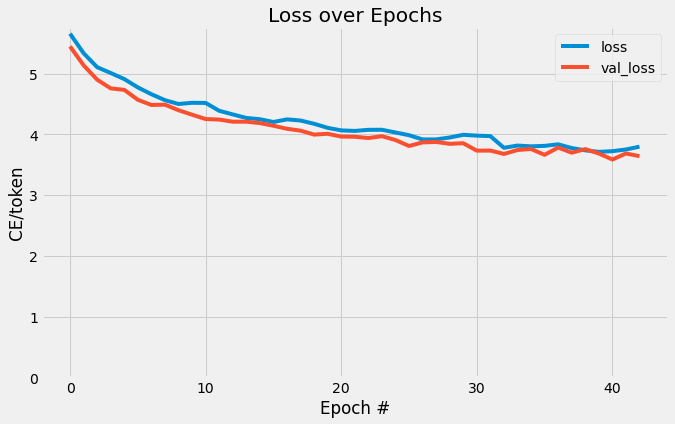

In [234]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch #")
plt.ylabel("CE/token")
plt.title("Loss over Epochs")
plt.legend()

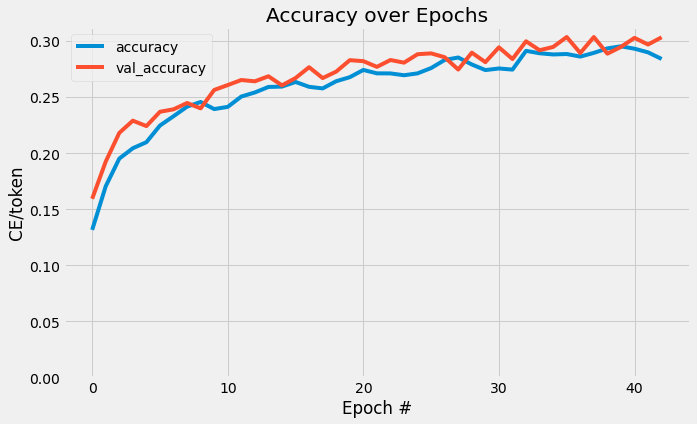

In [235]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["masked_acc"], label="accuracy")
plt.plot(history.history["val_masked_acc"], label="val_accuracy")
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch #")
plt.ylabel("CE/token")
plt.title("Accuracy over Epochs")
plt.legend()


In [277]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):

    def plot_attention_maps(image, str_tokens, attention_map):
        fig = plt.figure(figsize=(20, 9))

        len_result = len(str_tokens)

        titles = []
        for i in range(len_result):
            map = attention_map[i]
            grid_size = max(int(np.ceil(len_result / 2)), 2)
            ax = fig.add_subplot(3, grid_size, i + 1)
            titles.append(ax.set_title(str_tokens[i]))
            img = ax.imshow(image)
            ax.imshow(
                map,
                cmap="gray",
                alpha=0.6,
                extent=img.get_extent(),
                clim=[0.0, np.max(map)],
            )
            plt.axis("off")

        plt.tight_layout()

    result_txt = self.simple_gen(image, temperature)
    str_tokens = result_txt.split()
    str_tokens.append("[END]")

    attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
    attention_maps = tf.concat(attention_maps, axis=0)
    attention_maps = einops.reduce(
        attention_maps,
        "batch heads sequence (height width) -> sequence height width",
        height=7,
        width=7,
        reduction="mean",
    )

    plot_attention_maps(image / 255, str_tokens, attention_maps)
    t = plt.suptitle(f"Predicted Caption: {result_txt}")
    t.set_y(1.05)

## Evaluating Model Performance

In [258]:
def evaluate_bleu_score(samples: int=1):
    '''
    Validate model performance based on BLEU score of predicted captions using unseen test samples.
    '''
    actual, predicted = list(), list()

    for key, captions in tqdm(sample(test_captions, samples)):
        # predict caption
        image = load_image(key)
        y_pred = model.simple_gen(image)
        y_pred = y_pred.split()
        predicted.append(y_pred)
        # append actual captions
        actual_captions = [clean_caption(caption).split() for caption in captions]
        actual.append(actual_captions)
        
    # calcuate BLEU score
    print('BLEU-1:', corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2:', corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [259]:
evaluate_bleu_score(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1: 0.5041910667125962
BLEU-2: 0.3104897675442636


In [278]:
def predict(image):
    image_path = tf.keras.utils.get_file(origin=image)

    original_image = load_image(image_path, preserve_aspect_ratio=True)
    plt.imshow(original_image/255)
    plt.title("Original Image")
    plt.axis("off")

    image = load_image(image_path)
    run_and_show_attention(model, image)

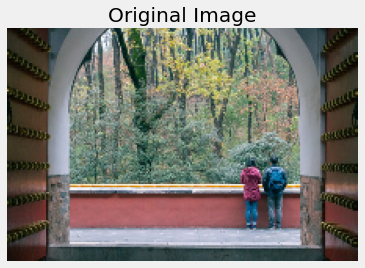

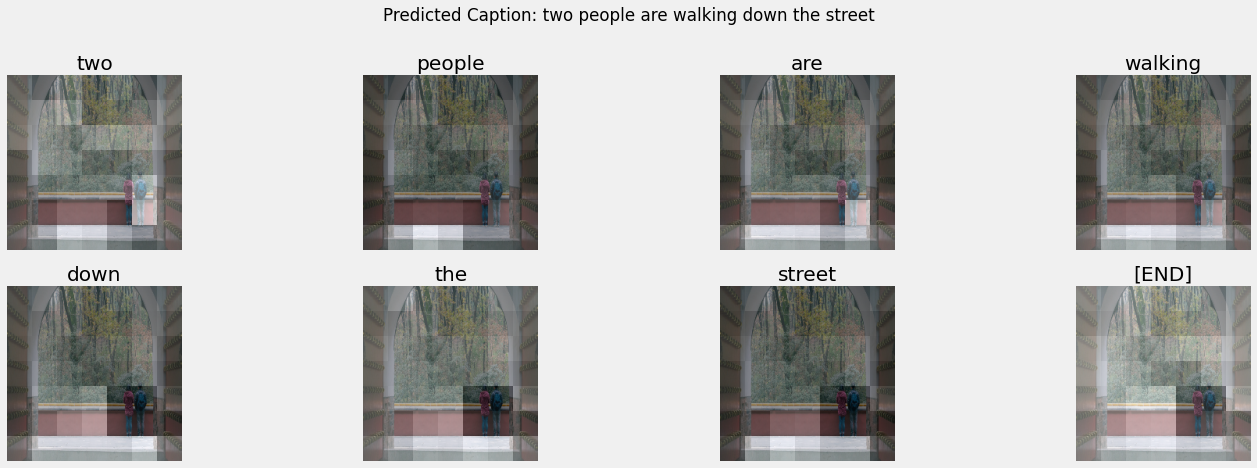

In [279]:
predict("https://live.staticflickr.com/65535/51239178976_b8e2f73175.jpg")

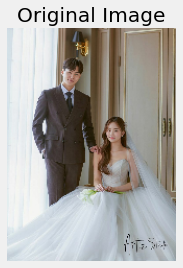

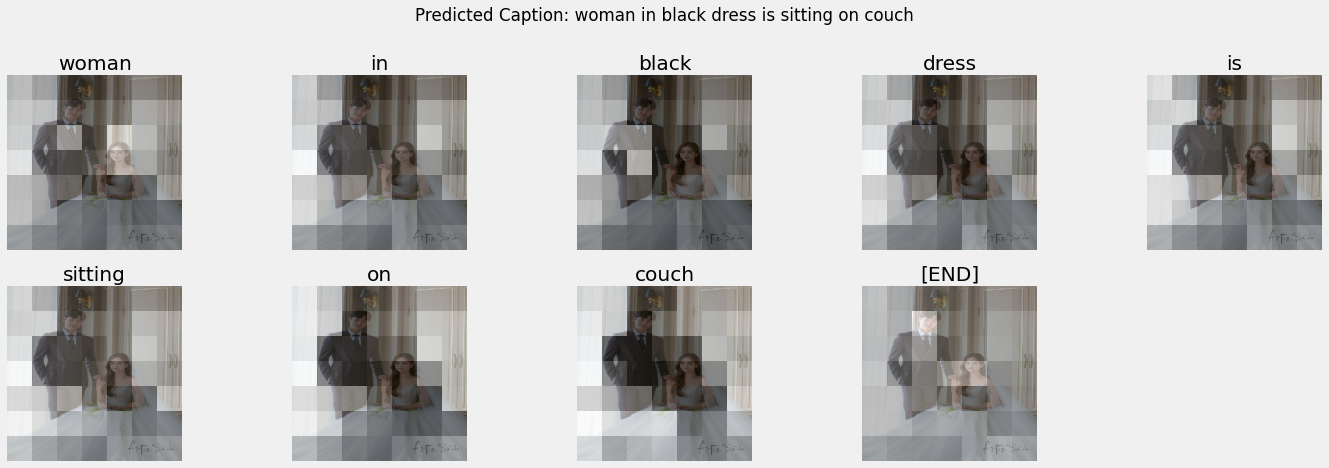

In [281]:
predict("https://media.herworld.com/public/2021/04/korea_artiz_studio_pre-wedding_photography_singapore_2-768x1061.jpg?compress=true&quality=80&w=480&dpr=2.6")

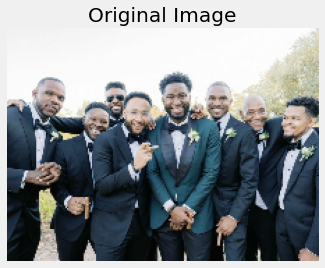

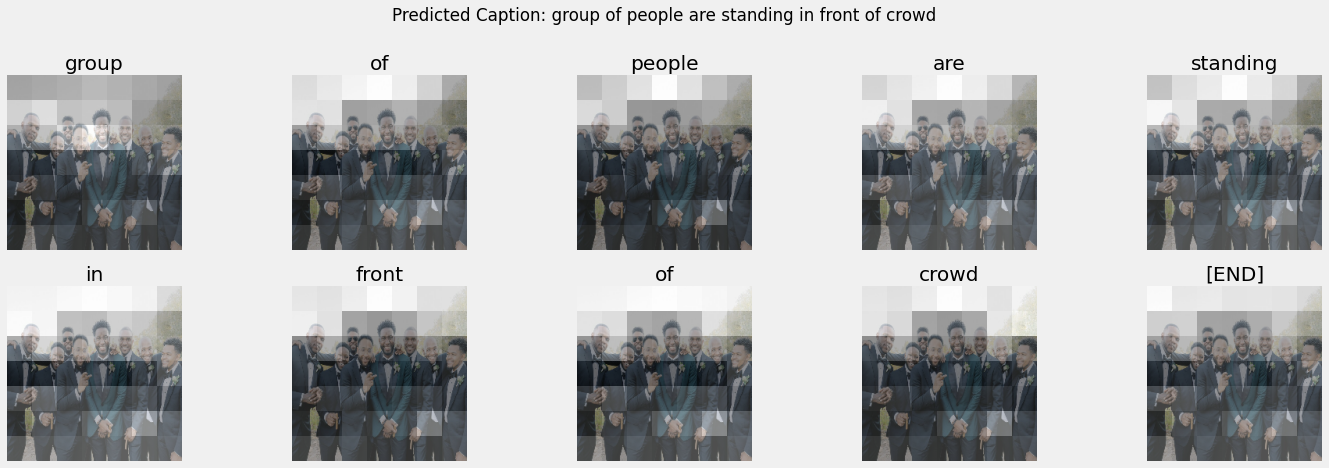

In [282]:
predict("https://www.theknot.com/tk-media/images/8e5250d2-f223-44d2-95e2-4768e7455319~rs_768.h")

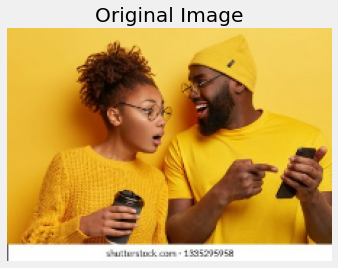

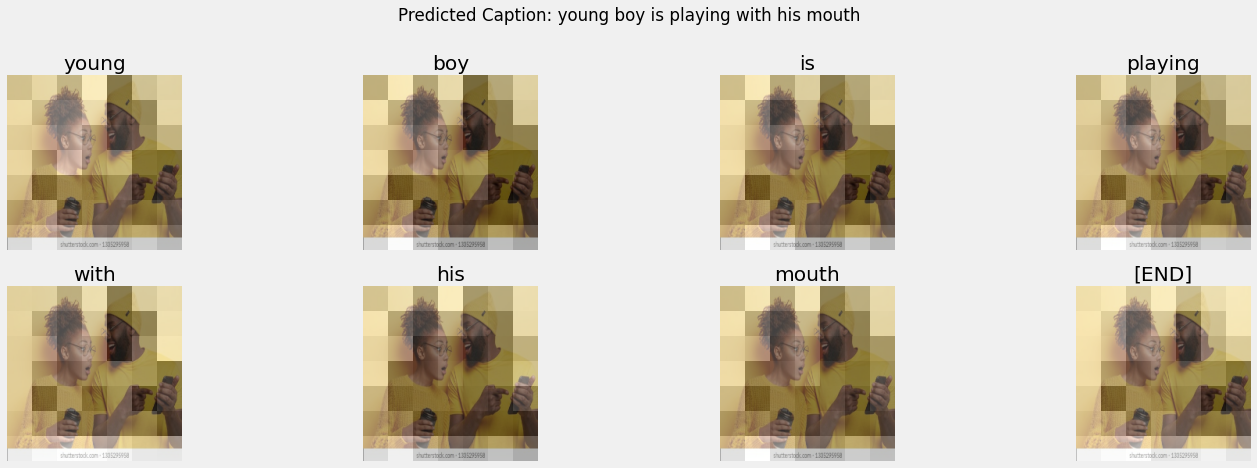

In [283]:
predict("https://www.shutterstock.com/image-photo/surprised-curious-dark-skinned-woman-260nw-1335295958.jpg")

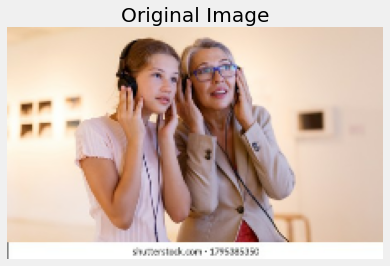

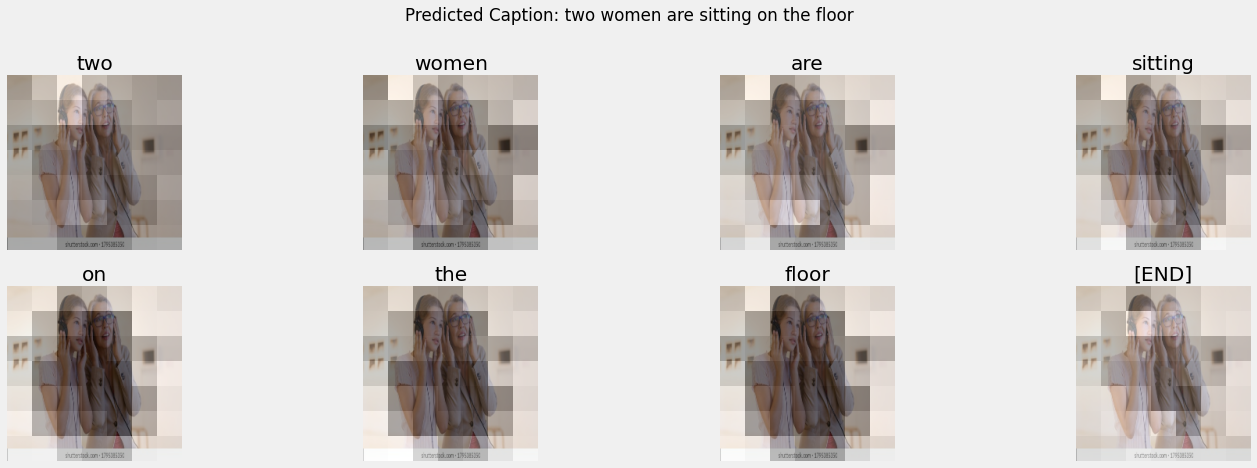

In [284]:
predict("https://www.shutterstock.com/image-photo/senior-female-tutor-tweenage-girl-260nw-1795385350.jpg")

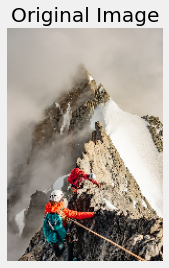

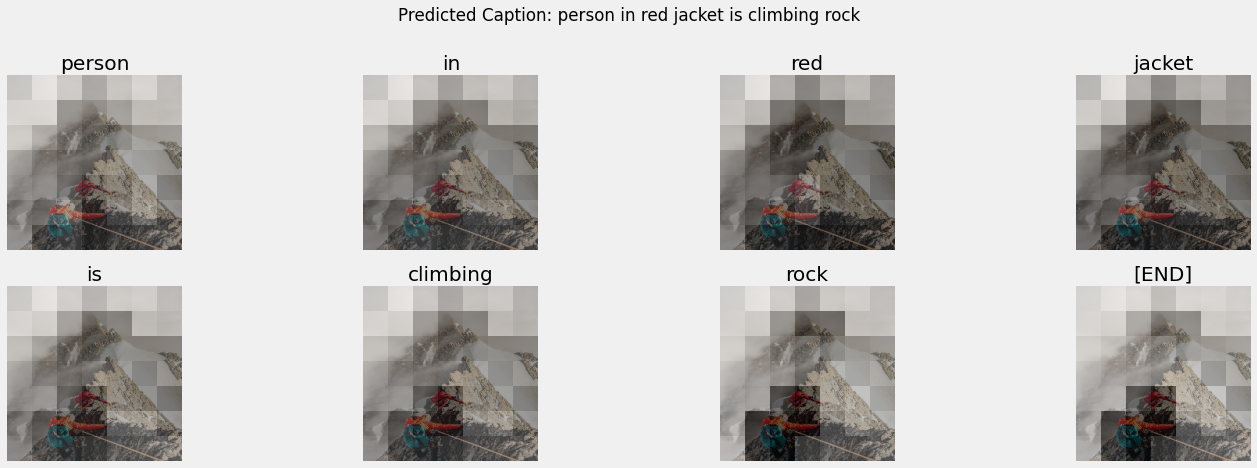

In [285]:
predict("https://images.unsplash.com/photo-1597250861267-429663f244a8?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8NHx8bW91bnRhaW4lMjBjbGltYmluZ3xlbnwwfHwwfHw%3D&w=1000&q=80")

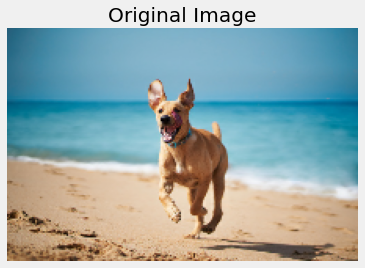

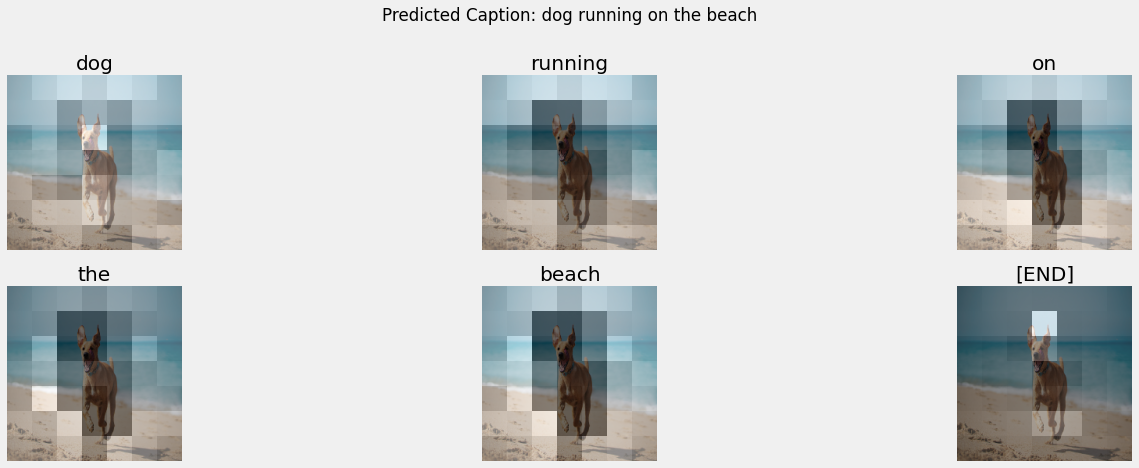

In [280]:
predict("https://media.istockphoto.com/id/1327737045/photo/happy-dog-running-on-beach.jpg?b=1&s=170667a&w=0&k=20&c=rlW-TsSSGwMg3Ia6j0fp7e1vzm_dQ-0SwIilhdmjW5Q=")


72478/72478 [==============================] - 0s 3us/step


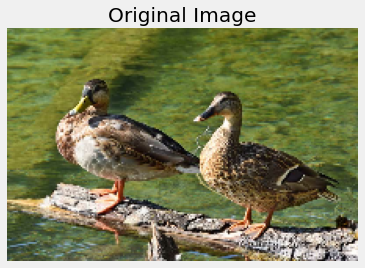

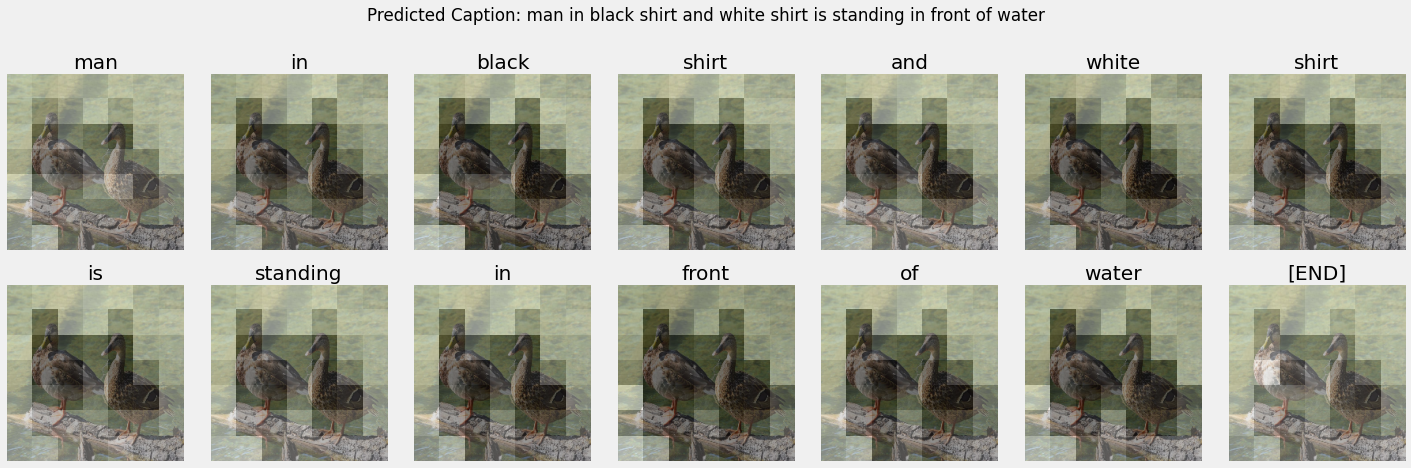

In [289]:
predict("https://www.birdspot.co.uk/wp-content/uploads/2021/03/ducks.jpg")

382265/382265 [==============================] - 0s 0us/step


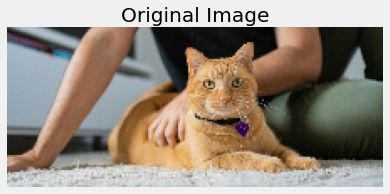

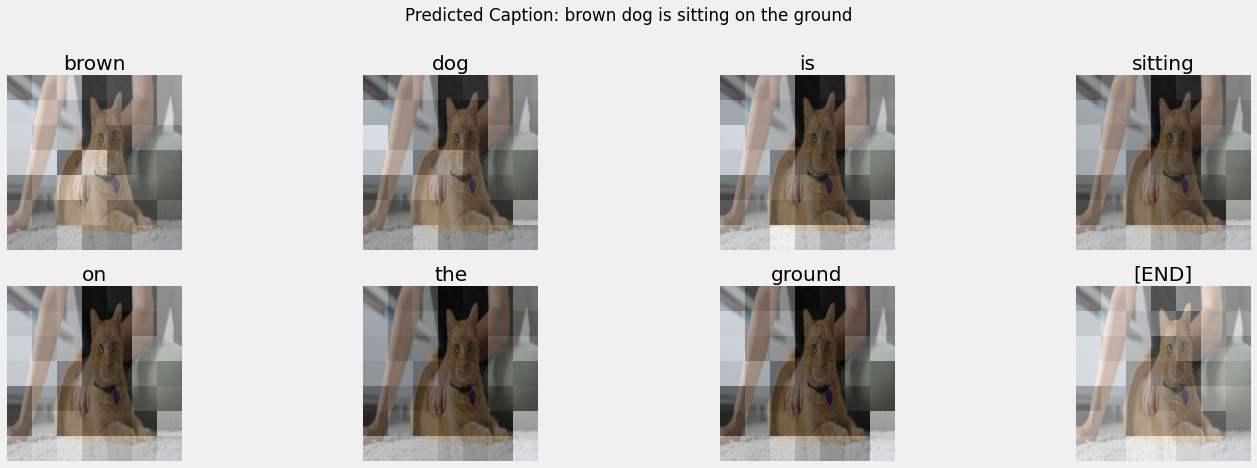

In [290]:
predict("https://www.humanesociety.org/sites/default/files/2022-10/cat-583009.jpg")

In [302]:
df_clean.query("Word in ('dog', 'cat', 'duck')")

Word  Count   Percent
220    dog   9090  0.005433
3471   cat    227  0.000136
907   duck     73  0.000044

## Deployment

In [264]:
# clear any existing files before saving the weights
!rm -r {MODEL_PATH + "/attention_weights/"}
model.save_weights(MODEL_PATH + "/attention_weights/")


## Resources

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/